# 虚假人脸检测实验

加载数据集,并划分数据集

In [15]:
from __future__ import print_function, division
import os
import random,shutil
# 给定一个人脸数据集，其中包含1999张真实人脸，1999张虚假人脸。
# 将其中500张真实人脸和500张虚假人脸作为训练集，其余作为测试集

#数据路径
# real_face_path='./CNN_synth_testset/0_real'
# fake_face_path='./CNN_synth_testset/1_fake'
face_dataset_path='./CNN_synth_testset'

#获取文件夹下所有文件名
def listDir(path):
    file_list=os.listdir(path)
    return file_list
#创建文件夹
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

#划分训练集和测试集和验证集
divided_data_path='./face_data_divided/'
def datasetDivide(divide_path):
    # 读取真实人脸和虚假人脸数据路径
    path=os.listdir(face_dataset_path)
    for doc in path:
        data=os.listdir(os.path.join(face_dataset_path,doc))
        #将人脸数据清洗
        random.shuffle(data)
        train_face_data=data[:500]
        valid_face_data=data[500:1999]
        # test_face_data=[]#
        mkdir(divide_path+'train/'+doc+'/')
        mkdir(divide_path+'validation/'+doc+'/')
        # mkdir(divide_path+'test/'+doc+'/')
        for train_face in train_face_data:
            shutil.copy(os.path.join(face_dataset_path,doc,train_face),
                        divide_path+'train/'+doc+'/'+train_face)
            
        for valid_face in valid_face_data:
            shutil.copy(os.path.join(face_dataset_path,doc,valid_face),
                        divide_path+'validation/'+doc+'/'+valid_face)
            
    print('数据集划分完成')
    
datasetDivide(divided_data_path)


数据集划分完成


res18模型构建

In [18]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
import numpy as np
import os

# 超参数
learning_rate = 0.001
batch_size = 4
num_epochs = 20

cudnn.benchmark = True#加速卷积神经网络的训练

In [19]:
# 数据预处理——数据增强
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.RandomCrop(224),  # 随机裁剪
        transforms.ToTensor(),  # 转换为张量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 归一化
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),  # 缩放为256×256
        transforms.CenterCrop(224),  # 中心裁剪为224×224
        transforms.ToTensor(),  # 转换为张量，且值缩放到[0,1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 归一化
    ]),
}

#加载数据集
data_path=divided_data_path
image_datasets = {x: datasets.ImageFolder(os.path.join(divided_data_path, x),
                                            data_transforms[x])
                    for x in ['train', 'validation']}
# print(image_datasets)
#数据的批量加载
#num_workers=0表示单线程，因为在windows不支持多线程
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                shuffle=True, num_workers=4)
                for x in ['train', 'validation']}
#数据集大小
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
# print(dataset_sizes)
#类别名称
class_names = image_datasets['train'].classes
# print(class_names)
#GPU是否可用
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


数据集显示

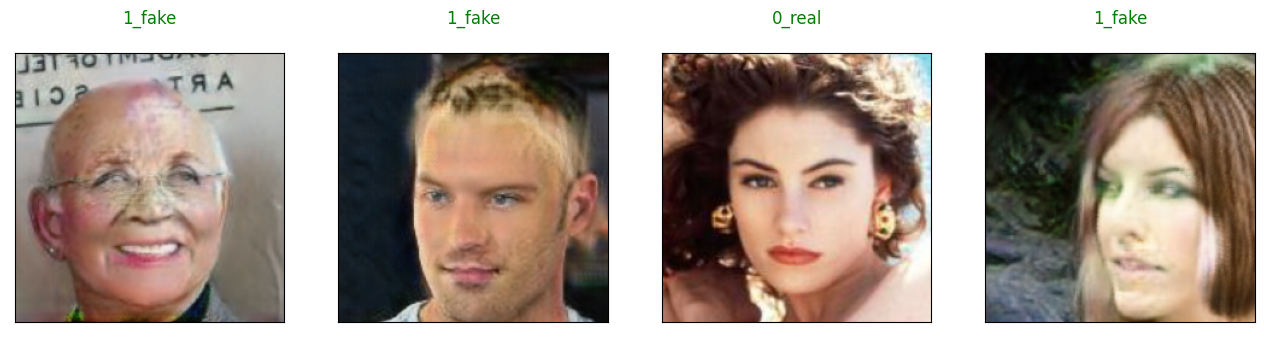

In [11]:
import matplotlib.pyplot as plt
import numpy as np


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

def plot_images(images, labels, preds=None):
    """
    Plot a batch of images with their labels and predictions (if given).

    Args:
        images (tensor): A batch of images.
        labels (tensor): The true labels for each image.
        preds (tensor, optional): The predicted labels for each image. Defaults to None.
    """
    # Set up the figures
    num_images = len(images)
    cnt=0
    plt.figure(figsize=(16, 16))
    # Plot each image
    for i in range(num_images):
        cnt+=1
        plt.subplot(1, num_images, cnt)
        plt.xticks([], [])#设置x轴刻度
        plt.yticks([], [])#设置y轴刻度
        # Set the title
        if preds is not None:
            title = f"predicted: {class_names[preds[i]]}, true: {class_names[labels[i]]}\n"
            color = 'green' if preds[i] == labels[i] else 'red'
        else:
            title = f"{class_names[labels[i]]}\n"
            color = 'green'        
        plt.title(title, color=color)
        # Unnormalize the image
        image = images[i].numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        

    plt.show()

plot_images(inputs, classes)


In [7]:
from tqdm import tqdm
from torch.optim import lr_scheduler
import copy,time
def train_model(model, criterion, optimizer,scheduler,num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    start_time = time.time()
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    
    pbar=tqdm(range(num_epochs))
    for epoch in pbar:
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-"*10}')
        
        # 每个 epoch 都有一个培训和验证阶段
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # 将模型设置为训练模式
            else:
                model.eval()   # 将模型设置为评估模式
            
            running_loss = 0.0#记录损失
            running_corrects = 0#记录正确的个数
            
            # 包装器tqdm，用于显示进度条
            # data_loader = tqdm(dataloaders[phase], desc=f'{phase} {epoch+1}/{num_epochs}')
            
            # 迭代数据
            for inputs, labels in  dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零参数梯度
                optimizer.zero_grad()

                # 前向传递
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 只有在训练阶段才进行反向传递+优化
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # 更新学习率
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                scheduler.step()#对优化器的学习率进行调整
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                
            # print(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')
            
            pbar.set_postfix_str(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')
            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy: {best_acc:.4f}')
    
    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)

    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

#加载预训练模型
model_ft = models.resnet18(pretrained=True)

# #冻结所有参数
# for param in model_ft.parameters():
#     param.requires_grad = False

#替换最后一层的分类器
#数据集只有两个类别（真实人脸和虚假人脸），因此新的全连接层的输出维度为2。
num_features=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_features,len(class_names))

#定义损失函数和优化器
model_ft=model_ft.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model_ft.parameters(),lr=learning_rate,momentum=0.9)

#学习率调整器
exp_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

#训练模型
model_ft, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

d:\APPdata\anaconda\envs\deepl\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
d:\APPdata\anaconda\envs\deepl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15
----------


  7%|▋         | 1/15 [01:06<15:36, 66.93s/it, validation loss: 0.1962, acc: 0.9273]

Epoch 2/15
----------


 13%|█▎        | 2/15 [02:06<13:34, 62.69s/it, validation loss: 0.0066, acc: 0.9975]

Epoch 3/15
----------


 20%|██        | 3/15 [03:07<12:23, 61.93s/it, validation loss: 0.0146, acc: 1.0000]

Epoch 4/15
----------


 27%|██▋       | 4/15 [04:00<10:43, 58.52s/it, validation loss: 0.0086, acc: 1.0000]

Epoch 5/15
----------


 33%|███▎      | 5/15 [04:53<09:23, 56.30s/it, validation loss: 0.0039, acc: 1.0000]

Epoch 6/15
----------


 40%|████      | 6/15 [05:48<08:23, 55.99s/it, validation loss: 0.0119, acc: 0.9995]

Epoch 7/15
----------


 47%|████▋     | 7/15 [06:42<07:22, 55.34s/it, validation loss: 0.0008, acc: 1.0000]

Epoch 8/15
----------


 53%|█████▎    | 8/15 [07:36<06:23, 54.86s/it, validation loss: 0.0006, acc: 1.0000]

Epoch 9/15
----------


 60%|██████    | 9/15 [08:30<05:27, 54.55s/it, validation loss: 0.0008, acc: 1.0000]

Epoch 10/15
----------


 67%|██████▋   | 10/15 [09:23<04:30, 54.04s/it, validation loss: 0.0004, acc: 1.0000]

Epoch 11/15
----------


 73%|███████▎  | 11/15 [10:13<03:31, 52.78s/it, validation loss: 0.0004, acc: 1.0000]

Epoch 12/15
----------


 80%|████████  | 12/15 [11:03<02:35, 51.99s/it, validation loss: 0.0005, acc: 1.0000]

Epoch 13/15
----------


 87%|████████▋ | 13/15 [11:53<01:42, 51.42s/it, validation loss: 0.0003, acc: 1.0000]

Epoch 14/15
----------


 93%|█████████▎| 14/15 [12:46<00:51, 51.93s/it, validation loss: 0.0004, acc: 1.0000]

Epoch 15/15
----------


100%|██████████| 15/15 [13:41<00:00, 54.75s/it, validation loss: 0.0004, acc: 1.0000]

Training complete in 13m 41s
Best validation accuracy: 1.0000


In [1]:
#可视化训练过程
def plot_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(train_loss_history, label='train')
    plt.plot(val_loss_history, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # plt.figure(figsize=(15, 5))
    # plt.subplot(122)
    # plt.plot(train_acc_history, label='train')
    # plt.plot(val_acc_history, label='validation')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.show()
    
    

def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            plot_images(inputs.cpu(), preds, labels)
            images_so_far += batch_size

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
        model.train(mode=was_training)
        
visualize_model(model_ft)
plot_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history)


NameError: name 'model_ft' is not defined

In [2]:
print(model_ft)

NameError: name 'model_ft' is not defined